In [1]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [2]:
import escher
from escher import Builder
from cobra.io import read_sbml_model, load_model
from utils.cobra_utils import get_or_create_exchange

model = read_sbml_model('../model/Rpom_05.xml')
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

ecoli = load_model("iJO1366")
ecoli_ex_glc = ecoli.reactions.get_by_id("EX_glc__D_e")
ecoli_ex_ace = ecoli.reactions.get_by_id("EX_ac_e")
ecoli_ex_oxy = ecoli.reactions.get_by_id("EX_o2_e")
ecoli_ex_oxy.lower_bound = -20

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [3]:
CARBONS_PER_GLUCOSE = 6
CARBONS_PER_ACETATE = 2

# Get glucose fluxome
with model:
    ex_glc.lower_bound = -5 / CARBONS_PER_GLUCOSE
    sol = model.optimize()
    glc_fluxes = sol.fluxes

# Get acetate fluxes
with model:
    ex_ace.lower_bound = -5 / CARBONS_PER_ACETATE
    sol = model.optimize()
    ace_fluxes = sol.fluxes

# Get names of reactions
rxn_names = glc_fluxes.index.values

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [4]:
with ecoli:
    ecoli_ex_glc.lower_bound = -5 / CARBONS_PER_GLUCOSE
    ecoli_glc_sol = ecoli.optimize()
    ecoli_glc_fluxes = ecoli_glc_sol.fluxes

# Get acetate fluxes
with ecoli:
    ecoli_ex_glc.lower_bound = 0
    ecoli_ex_ace.lower_bound = -5 / CARBONS_PER_ACETATE
    ecoli_ace_sol = ecoli.optimize()
    ecoli_ace_fluxes = ecoli_ace_sol.fluxes

# Get names of reactions
ecoli_rxn_names = ecoli_glc_fluxes.index.values

In [5]:
from ipywidgets import interact

comparison_data = [dict(zip(ecoli_ace_fluxes.index, ecoli_ace_fluxes.values + 1e-10)),
                   dict(zip(ecoli_glc_fluxes.index, ecoli_glc_fluxes.values + 1e-10)),                   
                   ]

data_options = [("glucose", ecoli_glc_fluxes),
                ("acetate", ecoli_ace_fluxes),
                ("comparison", comparison_data)]

map_options = ["iJO1366.Nucleotide metabolism",
               "iJO1366.Fatty acid biosynthesis (saturated)",
               "iJO1366.Nucleotide and histidine biosynthesis",
               "iJO1366.Central metabolism",
               "iJO1366.Fatty acid beta-oxidation"]


def plot_data(map, data):
    kwargs = {
        "map_name": map,
        "scroll_behavior": "zoom",
        "enable_tooltips": "label",
    }
    if isinstance(data, list):
        # Comparison data, need to change settings
        kwargs.update({
            "reaction_styles": ["color", "size", "text"],
            "reaction_compare_style": "log2_fold",
            "reaction_scale": [{
                'type': 'min',
                "color": '#d7191c'
            },
                {
                'type': 'value',
                "value": 0.0,
                "color": '#c8c8c8'
            },
                {
                'type': 'max',
                "color": '#2c7bb6'
            },
            ]
        })
        
    builder = Builder(**kwargs)

    builder.model = ecoli
    builder.reaction_data = data
    builder.height = 800
    return builder


def interact_plot_data(map, fluxes):
    selected_data = None
    for option in data_options:
        if option[0] == fluxes:
            selected_data = option[1]
            break
    if selected_data is not None:
        return plot_data(map, selected_data)
    else:
        return None


print("Comparisons are log2 fold changes of acetate vs glucose fluxes (Blue = more flux in glucose, Red = more flux in acetate)")
interact(interact_plot_data, map=map_options, fluxes=[
         option[0] for option in data_options])

Comparisons are log2 fold changes of acetate vs glucose fluxes (Blue = more flux in glucose, Red = more flux in acetate)


interactive(children=(Dropdown(description='map', options=('iJO1366.Nucleotide metabolism', 'iJO1366.Fatty aci…

<function __main__.interact_plot_data(map, fluxes)>

In [ ]:
# import requests
# import xmltodict
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from model_building.get_reaction_annotations import get_stem

# with open("../scraps/secret.txt", "r") as f:
#     user = f.readline().strip()
#     password = f.readline().strip()

# def get_bigg_id(reaction_id, user, password):
#     reaction_id = get_stem(reaction_id)

#     s = requests.Session()
#     s.post("https://websvc.biocyc.org/credentials/login/",
#             data={"email":user, "password":password})
#     r = s.get(f"https://websvc.biocyc.org/getxml?META:{reaction_id}&detail=full")
#     if r.status_code != 200:
#         return ""
#     o = xmltodict.parse(r.content)
    
#     links = o["ptools-xml"]["Reaction"].get("dblink", [])
#     if not isinstance(links, list):
#         links = [links]
    
#     for link in links:
#         if link["dblink-db"] == "BIGG":
#             return link["dblink-oid"]
    
#     return ""

# dblinks = []
# with tqdm(total=len(model.reactions)) as pbar:
#     with ThreadPoolExecutor() as executor:
#         futures = {executor.submit(get_bigg_id, reaction.id, user, password) : reaction for reaction in model.reactions}

#         for future in as_completed(futures):
#             reaction = futures[future]
#             try:
#                 bigg_id = future.result()
#                 reaction.notes["bigg.reaction"] = bigg_id
#                 dblinks.append({"Reaction" : reaction.id, "BIGG" : bigg_id})
#             except Exception as e:
#                 print(f"Error: {reaction.id} {e}")
            
#             pbar.update(1)


In [ ]:
# def get_bigg_id(metabolite_id, user, password):
#     metabolite_id = metabolite_id[:-3]

#     s = requests.Session()
#     s.post("https://websvc.biocyc.org/credentials/login/",
#             data={"email":user, "password":password})
#     r = s.get(f"https://websvc.biocyc.org/getxml?META:{metabolite_id}&detail=full")
#     if r.status_code != 200:
#         return ""
#     o = xmltodict.parse(r.content)
    
#     links = o["ptools-xml"].get("Compound",
#                                 o["ptools-xml"]["Protein"]).get("dblink", [])
#     if not isinstance(links, list):
#         links = [links]
    
#     for link in links:
#         if link["dblink-db"] == "BIGG":
#             return link["dblink-oid"]
    
#     return ""

# dblinks = []
# with tqdm(total=len(model.metabolites)) as pbar:
#     with ThreadPoolExecutor() as executor:
#         futures = {executor.submit(get_bigg_id, metabolite.id, user, password) : metabolite for metabolite in model.metabolites}

#         for future in as_completed(futures):
#             metabolite = futures[future]
#             try:
#                 bigg_id = future.result()
#                 metabolite.notes["BIGG"] = bigg_id
#                 dblinks.append({"Metabolite" : metabolite.id, "BIGG" : bigg_id})
#             except Exception as e:
#                 print(f"Error: {metabolite.id} {e}")
            
#             pbar.update(1)

In [8]:
import pandas as pd
dblinks = pd.read_excel("../figures/escher_diff_pathways.xlsx", sheet_name="Sheet2")
dblinks = [
    {"Metabolite" : row["Metabolite"], "BIGG" : row["BIGG"]}
    for _, row in dblinks.iterrows()
]

In [9]:
# Link reactions in iJO1366 to those in Rpom_05 using BIGG IDs of metabolites
def find_match(abs_stoich):
    best_match = None
    best_score = 0
    for reaction in model.reactions:  
        # Calculate score for matching  
        score = 0
        for met, coeff in reaction.metabolites.items():
            if met.id[:-3] in abs_stoich and abs(coeff) == abs_stoich[met.id[:-3]]:
                score += 1

        # Normalize score, penalizing missing metabolites
        score /= max(len(abs_stoich), len(reaction.metabolites))
        
        # Check if we've found a new best match
        if score > best_score:
            best_match = reaction.id
            best_score = score
        
    return best_match, best_score


bigg_to_biocyc = {metabolite["BIGG"] : metabolite["Metabolite"] for metabolite in dblinks}
for reaction in diff_reactions:
    reaction = ecoli.reactions.get_by_id(reaction["ID"])

    rpom_abs_stoich = {}
    for met in reaction.metabolites:
        biocyc_id = bigg_to_biocyc.get(met.id[:-2], "")[:-3]
        if biocyc_id == "":
            break
        # Can't assume direction of reaction, so take absolute value
        rpom_abs_stoich[biocyc_id] = abs(reaction.metabolites[met])
    
    best_match, score = find_match(rpom_abs_stoich)
    if score >= 0:
        print(f"{reaction.id}, {best_match}, {score}, {model.reactions.get_by_id(best_match).reaction if best_match is not None else ''}")

NameError: name 'diff_reactions' is not defined

In [10]:
data = pd.read_excel("escher_diff_pathways.xlsx")

# Filter to good matches
data = data[data["Score"] >= 0.5]

# Get log2 fold changes for R. pom
# Get glucose fluxome
with model:
    ex_glc.lower_bound = -5 / CARBONS_PER_GLUCOSE
    sol = model.optimize()
    glc_fluxes = sol.fluxes

# Get acetate fluxes
with model:
    ex_ace.lower_bound = -5 / CARBONS_PER_ACETATE
    sol = model.optimize()
    ace_fluxes = sol.fluxes

# Get names of reactions
rxn_names = glc_fluxes.index.values

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [11]:
data.columns

Index(['Map', 'Reaction', 'ID', 'BioCyc ID (Best match)',
       'Pathways (Best Match)', 'Score', 'Equation (Best Match)', 'Equation',
       'log2_fold'],
      dtype='object')

In [12]:
import numpy as np
log2fold_rpom = np.log2(ace_fluxes / glc_fluxes)
log2fold_ecoli = np.log2(ecoli_ace_fluxes / ecoli_glc_fluxes)

rpom_changes = log2fold_rpom[data["BioCyc ID (Best match)"]].values
ecoli_changes = log2fold_ecoli[data["ID"]].values

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


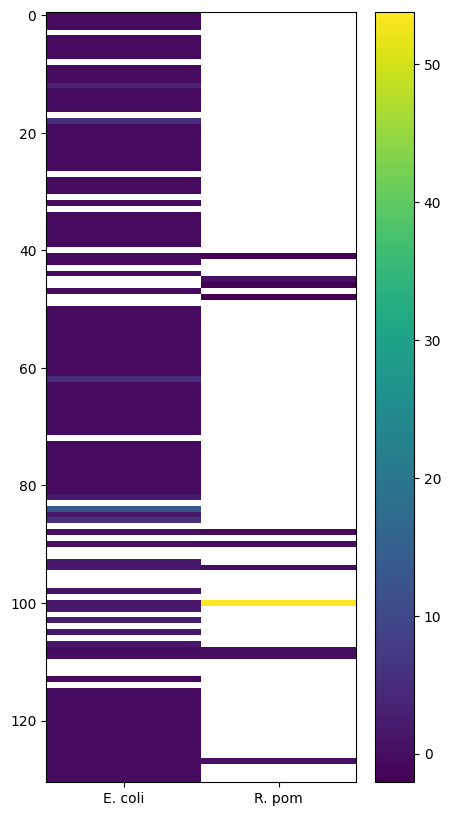

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(np.array([ecoli_changes, rpom_changes]).T, aspect="auto", interpolation="none")
ax.set_xticks([0, 1], ["E. coli", "R. pom"])
fig.colorbar(im)

fig.set_size_inches(5, 10)

In [15]:
log2fold_rpom.reset_index().to_clipboard()

In [18]:
# Get glucose fluxes to make map
with model:
    ex_glc.lower_bound = -10
    sol = model.optimize()
    glc_fluxes = sol.fluxes


builder = Builder(map_name="iJO1366.Central metabolism")
builder.reaction_data = glc_fluxes

builder

Builder(reaction_data={'1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN': 0.04788932695098856, '1.1.1.178-RXN': 0.0, '1.1.…

In [ ]:
model

Name,Rpom_05
Memory address,7fc422c6f130
Number of metabolites,1696
Number of reactions,1984
Number of genes,1250
Number of groups,0
Objective expression,1.0*Rpom_hwa_biomass - 1.0*Rpom_hwa_biomass_reverse_5ec2f
Compartments,"c, p, e"


In [17]:
# Get glucose fluxes to make map
with model:
    ex_glc.lower_bound = -10
    sol = model.optimize()
    glc_fluxes = sol.fluxes


builder = Builder(model=model, full_screen_button=False)
builder.height = 800
builder.reaction_data = glc_fluxes

builder

Builder(full_screen_button=False, height=800, reaction_data={'1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN': 0.04788932…

In [ ]:
glc_fluxes.sort_values(ascending=False).head(10)

Htex                                                        153.458735
1.10.2.2-RXN                                                 39.915288
1.6.99.5-RXN-NADH/UBIQUINONE-10/PROTON//NAD/CPD-9958.40.     39.538085
EX_h2o                                                       31.954833
ATPM                                                         30.000000
EX_co2                                                       21.934989
O2tex                                                        20.000000
O2tpp                                                        20.000000
CYTOCHROME-C-OXIDASE-RXN                                     19.999432
GAPOXNPHOSPHN-RXN                                            13.412635
Name: fluxes, dtype: float64

In [ ]:
for rxn in model.metabolites.get_by_id("PROTON[p]").reactions:
    if abs(rxn.flux) > 0:
        print(rxn.id, rxn.flux)
        print(f"\t{rxn.reaction}")

CYTOCHROME-C-OXIDASE-RXN 19.999432056830635
	4.0 Cytochromes-C-Reduced[p] + OXYGEN-MOLECULE[c] + 8.0 PROTON[c] --> 4.0 Cytochromes-C-Oxidized[p] + 4.0 PROTON[p] + 2.0 WATER[c]
Htex 153.4587349842195
	PROTON[e] <=> PROTON[p]
TRANS-RXN1G48-17-ZN+2/PROTON//ZN+2/PROTON.25. 0.00021711730380928753
	PROTON[p] + ZN+2[p] --> PROTON[c] + ZN+2[c]
TRANS-RXN1G48-18-CA+2/PROTON//CA+2/PROTON.25. 0.0033140632122945785
	CA+2[p] + PROTON[c] --> CA+2[c] + PROTON[p]
TRANS-RXN1G48-18-CU+2/PROTON//CU+2/PROTON.25. 0.00045142570666741787
	CU+2[p] + PROTON[c] --> CU+2[c] + PROTON[p]
TRANS-RXN1G48-18-FE+3/PROTON//FE+3/PROTON.25. 0.004971413175139941
	FE+3[p] + PROTON[c] --> FE+3[c] + PROTON[p]
ATPSYN-RXN -58.40808507111509
	ATP[c] + 3.0 PROTON[c] + WATER[c] <=> ADP[c] + 4.0 PROTON[p] + Pi[c]
RXN-14107 0.08357581578263612
	2.0 Cytochromes-C-Oxidized[p] + Menaquinols[c] --> 2.0 Cytochromes-C-Reduced[p] + Menaquinones[c] + 2.0 PROTON[p]
TRANS-RXN1G48-18-NI+2/PROTON//NI+2/PROTON.25. 0.0002056565627691815
	NI+2[p] +

In [ ]:
model.reactions.get_by_id("G6Ptex")

Reaction identifier,G6Ptex
Name,G6Ptex
Memory address,0x7f842306f1f0
Stoichiometry,D-glucopyranose-6-phosphate[e] <=> D-glucopyranose-6-phosphate[p] D-glucopyranose 6-phosphate <=> D-glucopyranose 6-phosphate
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
import warnings

from cobra.core import Reaction
# Try finding EGC's using Fritzemeier et. al approach

# ATP[cytosol] + H2O[cytosol] --> ADP[cytosol] + H(+)[cytosol] + Phosphate[cytosol]
# CTP[cytosol] + H2O[cytosol] --> CDP[cytosol] + H(+)[cytosol] + Phosphate[cytosol]
# GTP[cytosol] + H2O[cytosol] --> GDP[cytosol] + H(+)[cytosol] + Phosphate[cytosol]
# UTP[cytosol] + H2O[cytosol] --> UDP[cytosol] + H(+)[cytosol] + Phosphate[cytosol]
# ITP[cytosol] + H2O[cytosol] --> IDP[cytosol] + H(+)[cytosol] + Phosphate[cytosol]
# Nicotinamide adenine dinucleotide - reduced[cytosol] --> H(+)[cytosol] + Nicotinamide adenine dinucleotide[cytosol]
# Nicotinamide adenine dinucleotide phosphate - reduced[cytosol] --> H(+)[cytosol] + Nicotinamide adenine dinucleotide phosphate[cytosol]
# Flavin adenine dinucleotide reduced[cytosol] --> 2 H(+)[cytosol] + Flavin adenine dinucleotide oxidized[cytosol]
# Reduced FMN[cytosol] --> 2 H(+)[cytosol] + FMN[cytosol]
# Ubiquinol-8[cytosol] --> 2 H(+)[cytosol] + Ubiquinone-8[cytosol]
# Menaquinol 8[cytosol] --> 2 H(+)[cytosol] + Menaquinone 8[cytosol]
# 2-Demethylmenaquinol 8[cytosol] --> 2 H(+)[cytosol] + 2-Demethylmenaquinone 8[cytosol]
# H2O[cytosol] + Acetyl-CoA[cytosol] --> H(+)[cytosol] + Acetate[cytosol] + Coenzyme A[cytosol]
# L-Glutamate[cytosol] + H2O[cytosol] --> 2-Oxoglutarate[cytosol] + Ammonium[cytosol] + 2 H(+)[cytosol]
# H(+)[periplasm] --> H(+)[cytosol]

dissp_reactions = [
    {"ATP[c]" : -1, "WATER[c]" : -1, "ADP[c]" : 1, "PROTON[c]": 1, "Pi[c]": 1},
    {"CTP[c]" : -1, "WATER[c]" : -1, "CDP[c]" : 1, "PROTON[c]": 1, "Pi[c]": 1},
    {"GTP[c]" : -1, "WATER[c]" : -1, "GDP[c]" : 1, "PROTON[c]": 1, "Pi[c]": 1},
    {"UTP[c]" : -1, "WATER[c]" : -1, "UDP[c]" : 1, "PROTON[c]": 1, "Pi[c]": 1},
    {"ITP[c]" : -1, "WATER[c]" : -1, "IDP[c]" : 1, "PROTON[c]": 1, "Pi[c]": 1},
    {"NADH[c]" : -1, "PROTON[c]": 1, "NAD[c]": 1},
    {"NADPH[c]" : -1, "PROTON[c]": 1, "NADP[c]": 1},
    {"FADH2[c]" : -1, "PROTON[c]" : 2, "FAD[c]": 1},
    {"FMNH2[c]" : -1, "PROTON[c]" : 2, "FMN[c]": 1},
    {"CPD-9956[c]" : -1, "PROTON[c]" : 2, "UBIQUINONE-8[c]": 1},
    {"UBIQUINOL-30[c]" : -1, "PROTON[c]" : 2, "UBIQUINONE-6[c]": 1},
    {"CPD-9957[c]" : -1, "PROTON[c]" : 2, "UBIQUINONE-9[c]" : 1},
    {"CPD-9958[c]": -1, "PROTON[c]" : 2, "UBIQUINONE-10[c]": 1},
    
    {"WATER[c]" : -1, "ACETYL-COA[c]" : -1, "PROTON[c]" : 1, "ACET[c]": 1, "CO-A[c]": 1},
    {"GLT[c]" : -1, "WATER[c]" : -1, "2-KETOGLUTARATE[c]": 1, "AMMONIUM[c]": 1, "PROTON[c]": 2},
    {"PROTON[p]" : -1, "PROTON[c]": 1}
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for reaction in dissp_reactions:
        with model:
            # Create and add dissapation reaction
            dissp_rxn = Reaction("DISSP-RXN", "", "", 0, 1000)
            dissp_rxn.add_metabolites({
                model.metabolites.get_by_id(met) : coeff
                for met, coeff in reaction.items()
            })
            model.add_reactions([dissp_rxn])

            # Turn off uptake reactions
            for rxn in model.boundary:
                rxn.lower_bound = 0
                rxn.upper_bound = 0
            
            # Set dissapation as objective
            model.objective = dissp_rxn

            # Get check for flux through DISSP-RXN
            sol = model.optimize()
            print(f"{dissp_rxn.reaction} ({dissp_rxn.flux})")


ATP[c] + WATER[c] --> ADP[c] + PROTON[c] + Pi[c] (0.0)
CTP[c] + WATER[c] --> CDP[c] + PROTON[c] + Pi[c] (0.0)
GTP[c] + WATER[c] --> GDP[c] + PROTON[c] + Pi[c] (0.0)
UTP[c] + WATER[c] --> PROTON[c] + Pi[c] + UDP[c] (0.0)
ITP[c] + WATER[c] --> IDP[c] + PROTON[c] + Pi[c] (0.0)
NADH[c] --> NAD[c] + PROTON[c] (0.0)
NADPH[c] --> NADP[c] + PROTON[c] (0.0)
FADH2[c] --> FAD[c] + 2 PROTON[c] (0.0)
FMNH2[c] --> FMN[c] + 2 PROTON[c] (0.0)
CPD-9956[c] --> 2 PROTON[c] + UBIQUINONE-8[c] (0.0)
UBIQUINOL-30[c] --> 2 PROTON[c] + UBIQUINONE-6[c] (0.0)
CPD-9957[c] --> 2 PROTON[c] + UBIQUINONE-9[c] (0.0)
CPD-9958[c] --> 2 PROTON[c] + UBIQUINONE-10[c] (0.0)
ACETYL-COA[c] + WATER[c] --> ACET[c] + CO-A[c] + PROTON[c] (0.0)
GLT[c] + WATER[c] --> 2-KETOGLUTARATE[c] + AMMONIUM[c] + 2 PROTON[c] (0.0)
PROTON[p] --> PROTON[c] (0.0)


In [ ]:
{met.name for met in model.metabolites if "ubi" in met.id.lower() or "ubi" in met.name.lower()}

{'3-demethylubiquinol-10',
 '3-demethylubiquinol-6',
 '3-demethylubiquinol-8',
 '3-demethylubiquinol-9',
 'ubiquinol-10',
 'ubiquinol-6',
 'ubiquinol-8',
 'ubiquinol-9',
 'ubiquinone-10',
 'ubiquinone-6',
 'ubiquinone-8',
 'ubiquinone-9'}

In [ ]:
model.metabolites.get_by_id("UBIQUINONE-10[c]").formula

'C59H90O4'

In [ ]:
dissp_h_fluxes[dissp_h_fluxes!=0].sort_values().head(10)

2PGADEHYDRAT-RXN                -6.390799
GAPOXNPHOSPHN-RXN               -6.145287
EX_h2o                          -6.058559
PEPDEPHOS-RXN                   -4.533409
METHYLENETHFDEHYDROG-NADP-RXN   -4.344466
PDH                             -3.915756
EX_h                            -3.370573
GLCtex                          -3.186638
PGLUCISOM-RXN                   -3.186638
GLUCOKIN-RXN                    -3.186638
Name: fluxes, dtype: float64

In [ ]:
model.reactions.get_by_id("EX_h2o")

Reaction identifier,EX_h2o
Name,EX_h2o
Memory address,0x7f842303bd60
Stoichiometry,WATER[e] <=> H2O <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [29]:
from xml.etree import ElementTree as ET

glyc_svg = ET.parse("glycolysis.svg")

for node in glyc_svg.iter("data-rxn"):
    print(node)